    -[x] check variance of annotated segments in training data and validation data
    -[x] check class imbalance in training data
    -[x] percentage of annotated data in each recording

In [101]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import glob

import IPython.display as ipd

import explore


import librosa
import librosa.display
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set/Training_Set/'
csv_paths = glob.glob(os.path.join(root_path, '*/*.csv'))
wav_paths = [x.replace('csv', 'wav') for x in csv_paths]

In [103]:
subdirs = []
for csv_path in csv_paths:
    subdir = os.path.dirname(csv_path).split('/')[-1]
    subdirs.append(subdir)

subdirs = list(set(subdirs))

stats = {}
for subdir in subdirs:
    stats[subdir] = {
        'all_unknown' : [],
        'one_pos' : [],
        'many_pos' : [],
        'all_neg' : [],
        'rest' : [],
        'count' : 0,
        'classes' : [],
    }
    
def event_time(row):
    start_time = float(row[1][1])
    end_time = float(row[1][2])
    dt = end_time - start_time
    return dt
    
def count_classes(row):
    return len(row[1][3:])
    
def count_occurences(row, category):
    classes = row[1][3:]
    occurances = [1 if x else 0 for x in classes == category]
    
    return sum(occurances)

one_pos     = lambda row: count_occurences(row, 'POS') == 1
many_pos    = lambda row: count_occurences(row, 'POS') > 1
all_unknown = lambda row: count_occurences(row, 'UNK') == count_classes(row)
all_neg     = lambda row: count_occurences(row, 'NEG') == count_classes(row)
    
for csv_path in csv_paths:
    subdir = os.path.dirname(csv_path).split('/')[-1]
    annotation_df = pd.read_csv(csv_path)
    for row in annotation_df.iterrows():
        
        stats[subdir]['classes'] += list(row[1][3:].keys())
        
        if one_pos(row):
            stats[subdir]['one_pos'].append(row)
        elif many_pos(row):
            stats[subdir]['many_pos'].append(row)
        elif all_unknown(row):
            stats[subdir]['all_unknown'].append(row)
        elif all_neg(row):
            stats[subdir]['all_neg'].append(row)
        else:
            stats[subdir]['rest'].append(row)
        stats[subdir]['count'] += 1

In [104]:
total_count = 0
total_pos = 0
total_not_pos = 0
for subdir in subdirs:
    print('------------------------------------------')
    print('- ', subdir)
    print('------------------------------------------')
    print('nb_rest: ', len(stats[subdir]['rest']))
    print('nb_all_unknown: ', len(stats[subdir]['all_unknown']))
    print('nb_all_neg: ', len(stats[subdir]['all_neg']))
    print('nb_one_pos: ', len(stats[subdir]['one_pos']))
    print('nb_many_pos: ', len(stats[subdir]['many_pos']))

    
    
    print('n_classes: ', len(list(set(stats[subdir]['classes']))))
    
    total_pos += len(stats[subdir]['one_pos'])
    total_not_pos += stats[subdir]['count'] - len(stats[subdir]['one_pos'])
    
    total_count += stats[subdir]['count']
    
print("-----------------------------")
print("Total count: ", total_count)
print("Total pos: ", total_pos)
print("Total not pos", total_not_pos)

------------------------------------------
-  JD
------------------------------------------
nb_rest:  0
nb_all_unknown:  2
nb_all_neg:  0
nb_one_pos:  355
nb_many_pos:  0
n_classes:  1
------------------------------------------
-  MT
------------------------------------------
nb_rest:  36
nb_all_unknown:  24
nb_all_neg:  0
nb_one_pos:  1234
nb_many_pos:  0
n_classes:  4
------------------------------------------
-  HT
------------------------------------------
nb_rest:  8
nb_all_unknown:  118
nb_all_neg:  0
nb_one_pos:  485
nb_many_pos:  0
n_classes:  5
------------------------------------------
-  BV
------------------------------------------
nb_rest:  1881
nb_all_unknown:  3269
nb_all_neg:  1214
nb_one_pos:  2662
nb_many_pos:  0
n_classes:  11
------------------------------------------
-  WMW
------------------------------------------
nb_rest:  0
nb_all_unknown:  0
nb_all_neg:  0
nb_one_pos:  2941
nb_many_pos:  0
n_classes:  26
-----------------------------
Total count:  14229
Total 

------------------------------------------
-  JD
------------------------------------------
One pos     :  0.10443559154929866  +=  0.028481583151211614
total time:  37.074635000001024
Not one pos :  0.36053400000001545  +=  0.2668210000000073
total time:  0.7210680000000309
------------------------------------------
-  MT
------------------------------------------
One pos     :  0.14665721231765666  +=  0.08923506190361506
total time:  180.9749999999883
Not one pos :  0.19188333333330831  +=  0.17031765338790913
total time:  11.512999999998499
------------------------------------------
-  HT
------------------------------------------
One pos     :  1.3414886597938196  +=  0.8097168643339936
total time:  650.6220000000025
Not one pos :  1.4342063492063726  +=  0.6481614451718881
total time:  180.71000000000294
------------------------------------------
-  BV
------------------------------------------
One pos     :  0.1499999999999841  +=  3.5834136701918384e-13
total time:  399.2999999

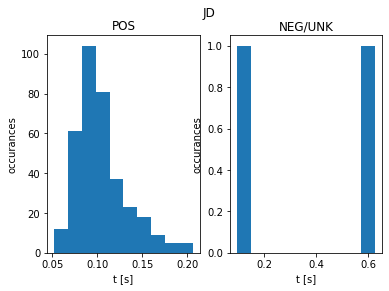

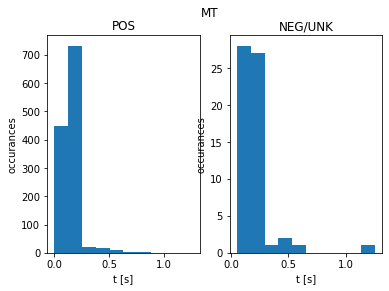

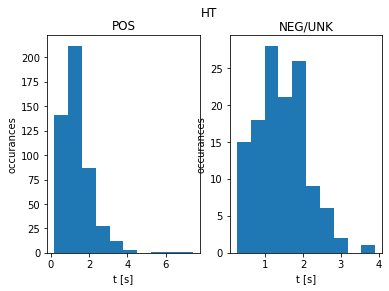

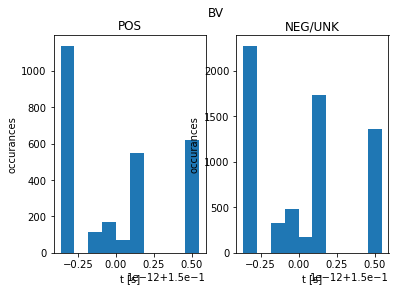

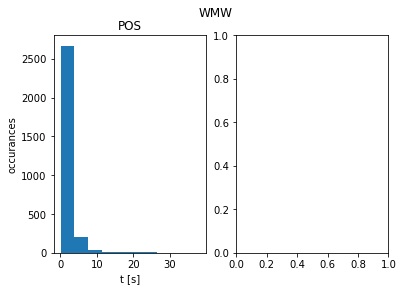

In [105]:
total_count = 0
total_pos = 0
total_not_pos = 0
for subdir in subdirs:
    print('------------------------------------------')
    print('- ', subdir)
    print('------------------------------------------')
    rest = stats[subdir]['rest']
    all_unknown = stats[subdir]['all_unknown']
    all_neg = stats[subdir]['all_neg']
    one_pos = stats[subdir]['one_pos']
    not_one_pos = rest + all_unknown + all_neg
    
    one_pos_times = []
    for row in one_pos:
        one_pos_times.append(event_time(row))
    not_one_pos_times = []
    for row in not_one_pos:
        not_one_pos_times.append(event_time(row))
    
    
    fig, ax = plt.subplots(1, 2)
    if len(one_pos_times) > 0:
        print("One pos     : ", np.mean(one_pos_times)," += ", np.std(one_pos_times))
        print("total time: ", np.sum(one_pos_times))
        ax[0].hist(one_pos_times)
        ax[0].set_title('POS')
        ax[0].set_xlabel('t [s]')
        ax[0].set_ylabel('occurances')
        #ax[0].set_xlim([0, 1])
    if len(not_one_pos_times) > 0:
        print("Not one pos : ", np.mean(not_one_pos_times)," += ", np.std(not_one_pos_times))
        print("total time: ", np.sum(not_one_pos_times))
        ax[1].hist(not_one_pos_times)
        ax[1].set_title('NEG/UNK')
        ax[1].set_xlabel('t [s]')
        ax[1].set_ylabel('occurances')
        #ax[1].set_xlim([0, 1])
    fig.suptitle(subdir)

In [108]:
classes = []
for subdir in subdirs:    
    classes += list(set(stats[subdir]['classes']))
classes = list(set(classes))

In [110]:
classes

['SNMK',
 'c_4',
 'c_26',
 'c_13',
 'c_22',
 'c_9',
 'c_11',
 'c_8',
 'c_24',
 'GIG',
 'c_21',
 'GRN',
 'COYE',
 'RBGR',
 'CHSP',
 'c_16',
 'c_17',
 'BTBW',
 'c_12',
 'BBWA',
 'c_20',
 'c_19',
 'WHP',
 'c_7',
 'AMRE',
 'WTSP',
 'GCTH',
 'c_23',
 'c_6',
 'c_14',
 'SAVS',
 'RUM',
 'AGGM',
 'c_2',
 'c_25',
 'CALL',
 'SQT',
 'SWTH',
 'SOCM',
 'c_3',
 'CCMK',
 'c_5',
 'c_10',
 'OVEN',
 'c_15',
 'c_1',
 'c_18']